In [13]:
import os

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import auc, roc_curve

from loss_traces.attacks import AttackConfig, LiRAAttack
from loss_traces.results.final_model_metrics import get_final_model_metrics
from loss_traces.results.result_processing import get_trace_reduction
from loss_traces.results.utils import make_precision_recall_at_k_df_single_threshold

plt.style.use("plot_style.mplstyle")

In [ ]:
target_id = "target"
attack = "LiRA"
augment = True
batchsize = 32
num_workers = 8
gpu = ":1"
dataset = "CIFAR10"
arch = "wrn28-2"

all_dfs = {}
for clipnorm in ("10", "3", "1"):
    for noise_multiplier in ("0", "0.1", "1"):
        exp_id = f"{arch}_{dataset}_clipnorm_{clipnorm}_nm_{noise_multiplier}"

        csv_path = f'data/trace_df_{arch}_{dataset}_clip{clipnorm}_nm_{noise_multiplier}.csv'
        if os.path.exists(csv_path):
            all_dfs[(clipnorm, noise_multiplier)] = pd.read_csv(csv_path, index_col=0)
            continue

        config = AttackConfig(
            exp_id=exp_id,
            target_id=target_id,
            checkpoint=None,
            arch=arch,
            dataset=dataset,
            attack=attack,
            augment=augment,
            batchsize=batchsize,
            num_workers=num_workers,
            gpu=gpu,
            is_dp=True,
        )
        attack = LiRAAttack(config)
        results = attack.run()

        df = get_final_model_metrics(
            model=attack.model, data_loader=attack.attack_loaders[0]
        )
        df = pd.merge(df, results, left_index=True, right_index=True)

        trace = get_trace_reduction(exp_id, reduction="iqr")
        trace_df = pd.DataFrame({'trace_value': trace})
        trace_df = pd.merge(trace_df, df, left_index=True, right_index=True)

        trace_df.to_csv(csv_path)
        all_dfs[(clipnorm, noise_multiplier)] = trace_df


In [41]:
dataset = "CIFAR10"
arch = "wrn28-2"

all_dfs = {}
for clipnorm in ("10", "3", "1"):
    for noise_multiplier in ("0", "0.1", "1"):
        exp_id = f"{arch}_{dataset}_clipnorm_{clipnorm}_nm_{noise_multiplier}"

        csv_path = f'data/trace_df_{arch}_{dataset}_clip{clipnorm}_nm_{noise_multiplier}.csv'
        if os.path.exists(csv_path):
            all_dfs[(clipnorm, noise_multiplier)] = pd.read_csv(csv_path, index_col=0)
            continue

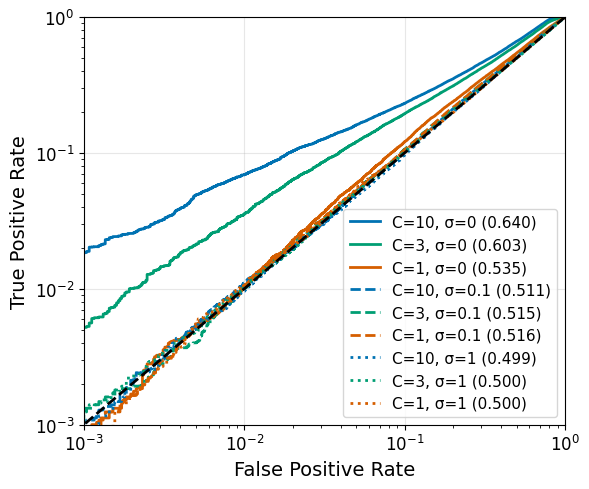

In [63]:
plt.figure(figsize=(6, 5))

linestyles = {
    "0": "-",    # solid
    "0.1": "--", # dashed 
    "1": ":"     # dotted
}

# ['0072B2', '009E73', 'D55E00'
colors = {
    "10": "#0072B2",  # blue - first default color
    "3": "#009E73",   # orange - second default color
    "1": "#D55E00"    # green - third default color
}

for noise in ("0", "0.1", "1"):
    for clipnorm in ("10", "3", "1"):
        if (clipnorm, noise) not in all_dfs:
            continue

        df = all_dfs[(clipnorm, noise)]

        y_true = df["target_trained_on"]
        y_scores = df["lira_score"]

        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2,
                color=colors[clipnorm],
                linestyle=linestyles[noise],
                label=f"C={clipnorm}, σ={noise} ({roc_auc:.3f})")

plt.plot([0, 1], [0, 1], color="black", lw=2, linestyle="--")
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.xscale("log")
plt.yscale("log")
plt.xlim(0.001, 1)
plt.ylim(0.001, 1)

plt.tight_layout()
plt.savefig('figures/dp_roc_all.pdf')


In [45]:
trace_df = all_dfs[("10", "0")]

k_values = [0.01, 0.03, 0.05]
results = {}
for k in k_values:
    result = make_precision_recall_at_k_df_single_threshold(
        scores_df=trace_df,
        ground_truth_df=trace_df,
        fpr_threshold=0.01,
        k_frac=k,
    )
    results[k] = result

metrics_df = pd.DataFrame.from_dict(results, orient='columns')
metrics_df.columns = [f'k={k}' for k in k_values]

pd.set_option('display.max_rows', 75)

metrics_df

,k=0.01,k=0.03,k=0.05
spearman_trace_value,0.287926,0.287926,0.287926
spearman_loss,0.023166,0.023166,0.023166
spearman_confidence,0.035354,0.035354,0.035354
spearman_param_grad_norm,0.170976,0.170976,0.170976
spearman_param_grad_var,0.170971,0.170971,0.170971
spearman_input_grad_norm,0.218725,0.218725,0.218725
spearman_input_grad_var,0.218725,0.218725,0.218725
spearman_shap_norm,0.239843,0.239843,0.239843
spearman_shap_var,0.238862,0.238862,0.238862
spearman_lira_score,1.000000,1.000000,1.000000


In [46]:
noise = "0"
k = 0.05

results = {}
for clipnorm in ["1", "3", "10"]:
    if (clipnorm, noise) in all_dfs:
        trace_df = all_dfs[(clipnorm, noise)]
        result = make_precision_recall_at_k_df_single_threshold(
            scores_df=trace_df,
            ground_truth_df=trace_df, 
            fpr_threshold=0.01,
            k_frac=k,
        )
        results[clipnorm] = result

metrics_df = pd.DataFrame.from_dict(results, orient='columns')
metrics_df.columns = [f'clipnorm={c}' for c in results.keys()]

pd.set_option('display.max_rows', 75)

metrics_df

,clipnorm=1,clipnorm=3,clipnorm=10
spearman_trace_value,0.085007,0.134805,0.287926
spearman_loss,0.176975,0.028132,0.023166
spearman_confidence,0.083240,0.005642,0.035354
spearman_param_grad_norm,0.145887,0.060638,0.170976
spearman_param_grad_var,0.145887,0.060638,0.170971
spearman_input_grad_norm,0.147425,0.044636,0.218725
spearman_input_grad_var,0.147425,0.044635,0.218725
spearman_shap_norm,0.094155,0.060838,0.239843
spearman_shap_var,0.094198,0.060555,0.238862
spearman_lira_score,1.000000,1.000000,1.000000


In [47]:
noise = "0"
k = 0.05
fpr_values = [0.1, 0.01, 0.001]

results = {}
for fpr in fpr_values:
    if (clipnorm, noise) in all_dfs:
        trace_df = all_dfs[(clipnorm, noise)]
        result = make_precision_recall_at_k_df_single_threshold(
            scores_df=trace_df,
            ground_truth_df=trace_df,
            fpr_threshold=fpr,
            k_frac=k,
        )
        results[fpr] = result

metrics_df = pd.DataFrame.from_dict(results, orient='columns')
metrics_df.columns = [f'fpr={fpr}' for fpr in fpr_values]

pd.set_option('display.max_rows', 75)

metrics_df

,fpr=0.1,fpr=0.01,fpr=0.001
spearman_trace_value,0.287926,0.287926,0.287926
spearman_loss,0.023166,0.023166,0.023166
spearman_confidence,0.035354,0.035354,0.035354
spearman_param_grad_norm,0.170976,0.170976,0.170976
spearman_param_grad_var,0.170971,0.170971,0.170971
spearman_input_grad_norm,0.218725,0.218725,0.218725
spearman_input_grad_var,0.218725,0.218725,0.218725
spearman_shap_norm,0.239843,0.239843,0.239843
spearman_shap_var,0.238862,0.238862,0.238862
spearman_lira_score,1.000000,1.000000,1.000000
